In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

output = "./submissions.csv"
df_train = pd.read_csv("./datasets/train.csv")
df_test = pd.read_csv("./datasets/test.csv")

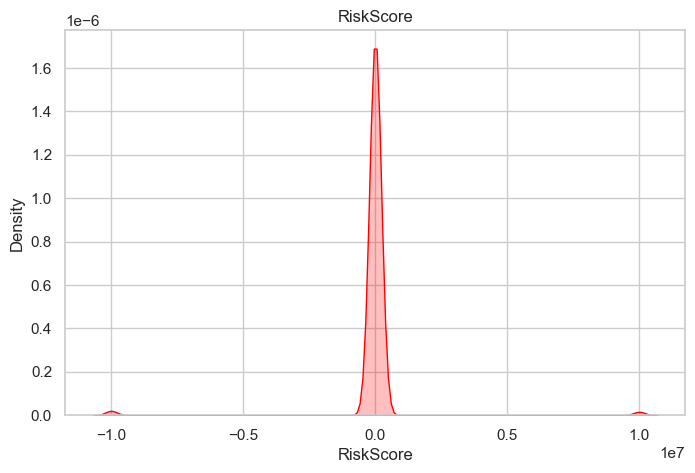

Количество числовых признаков: 29
Признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'RiskScore']
Топ положительных корреляций с RiskScore:
PaymentHistory               0.019144
TotalDebtToIncomeRatio       0.013879
MonthlyLoanPayment           0.012366
LoanAmount                   0.011771
NumberOfCreditInquiries      0.011055
NetWorth                     0.008804
TotalAssets                  0.008092
SavingsAccountBalance        0.007611
CreditCardUtilizationRate    0.0055

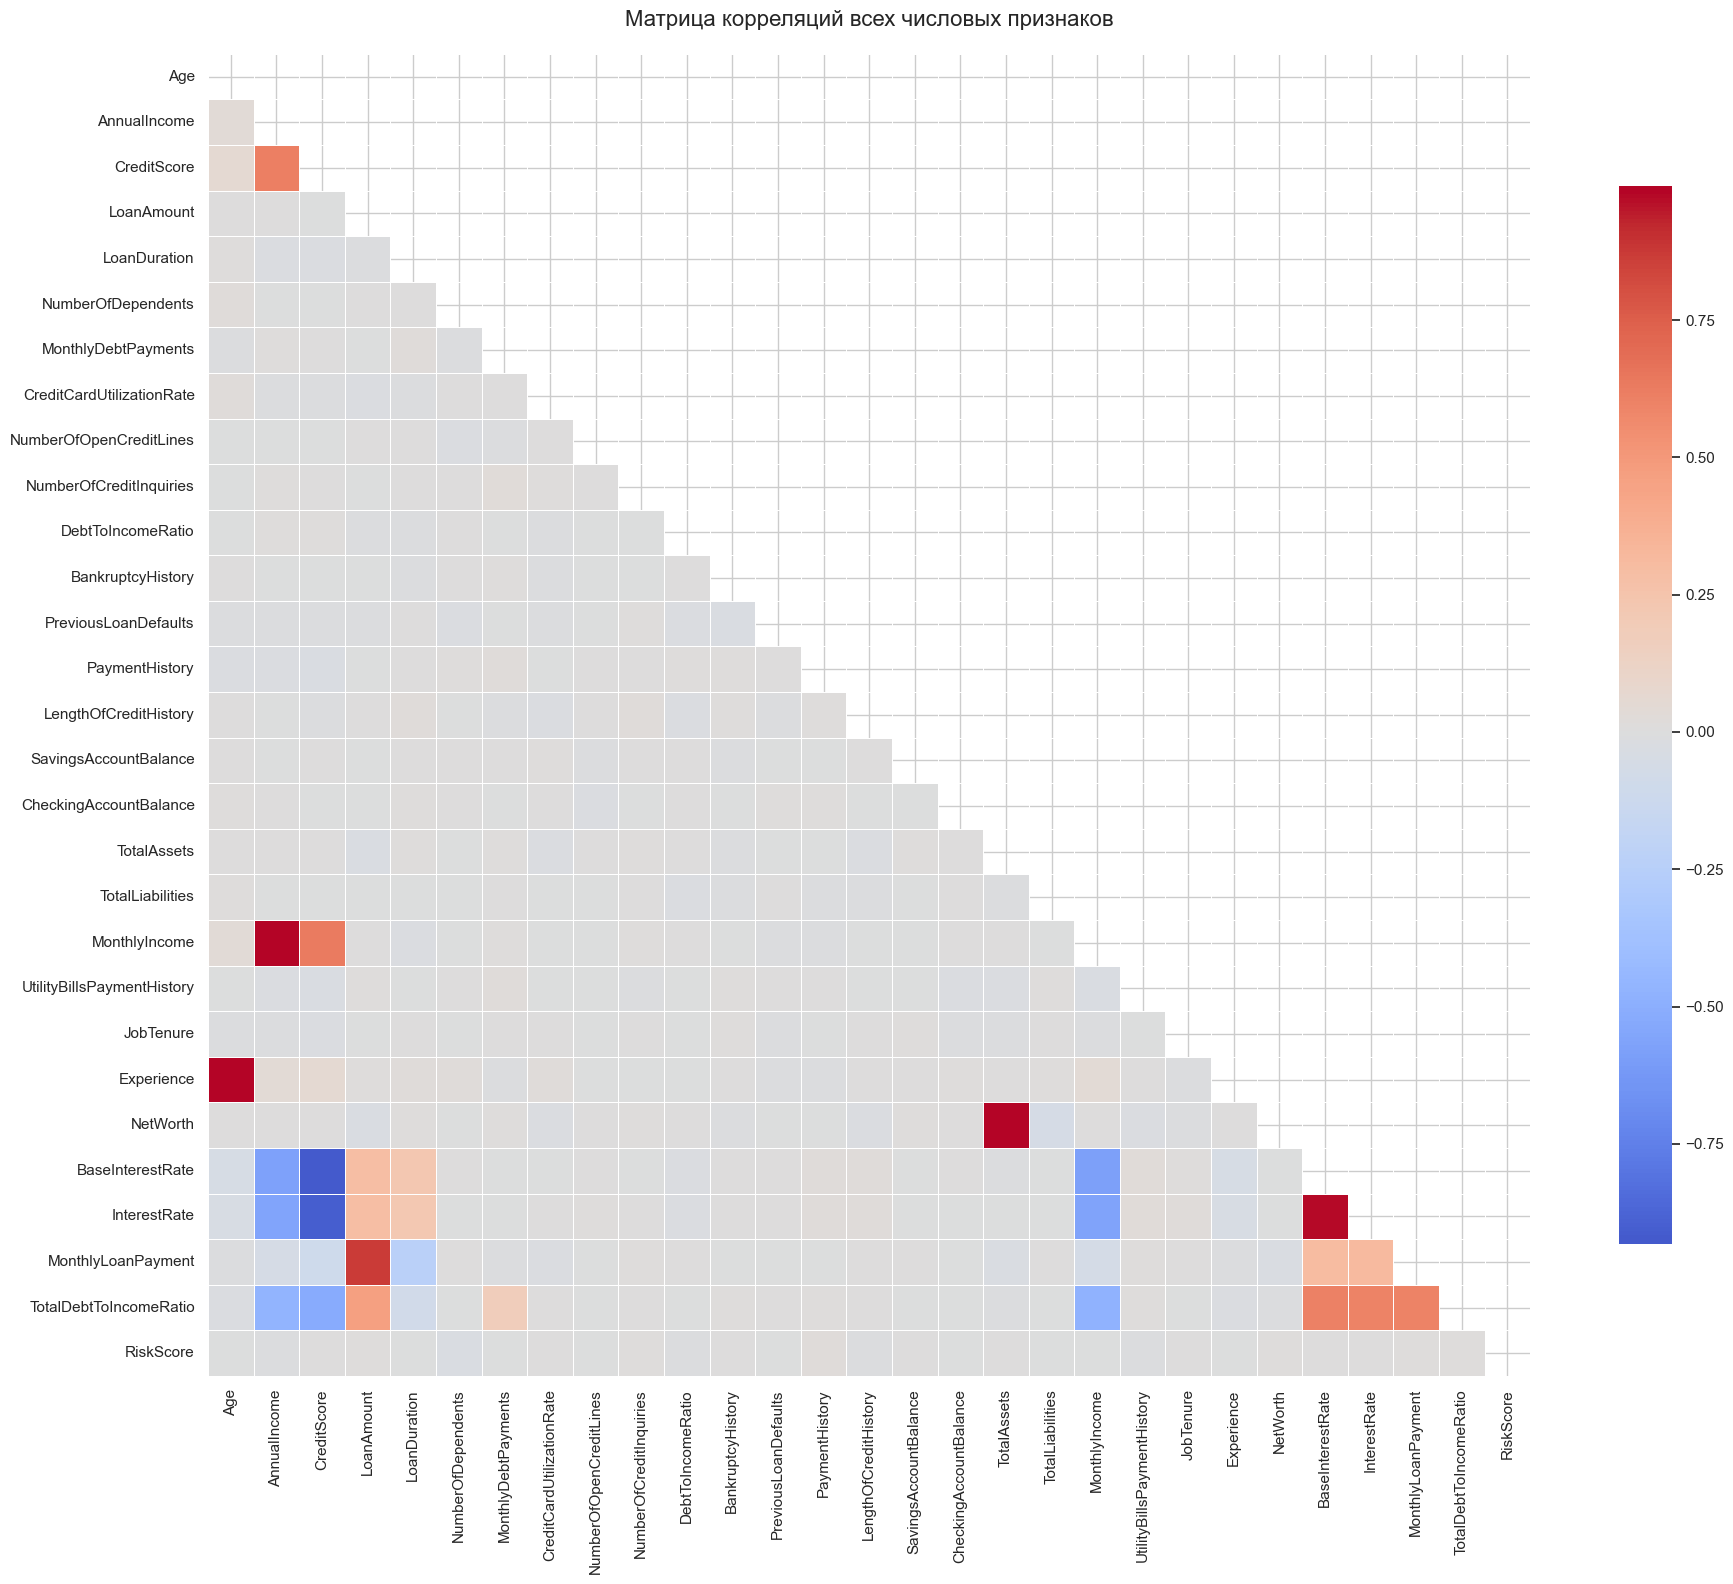

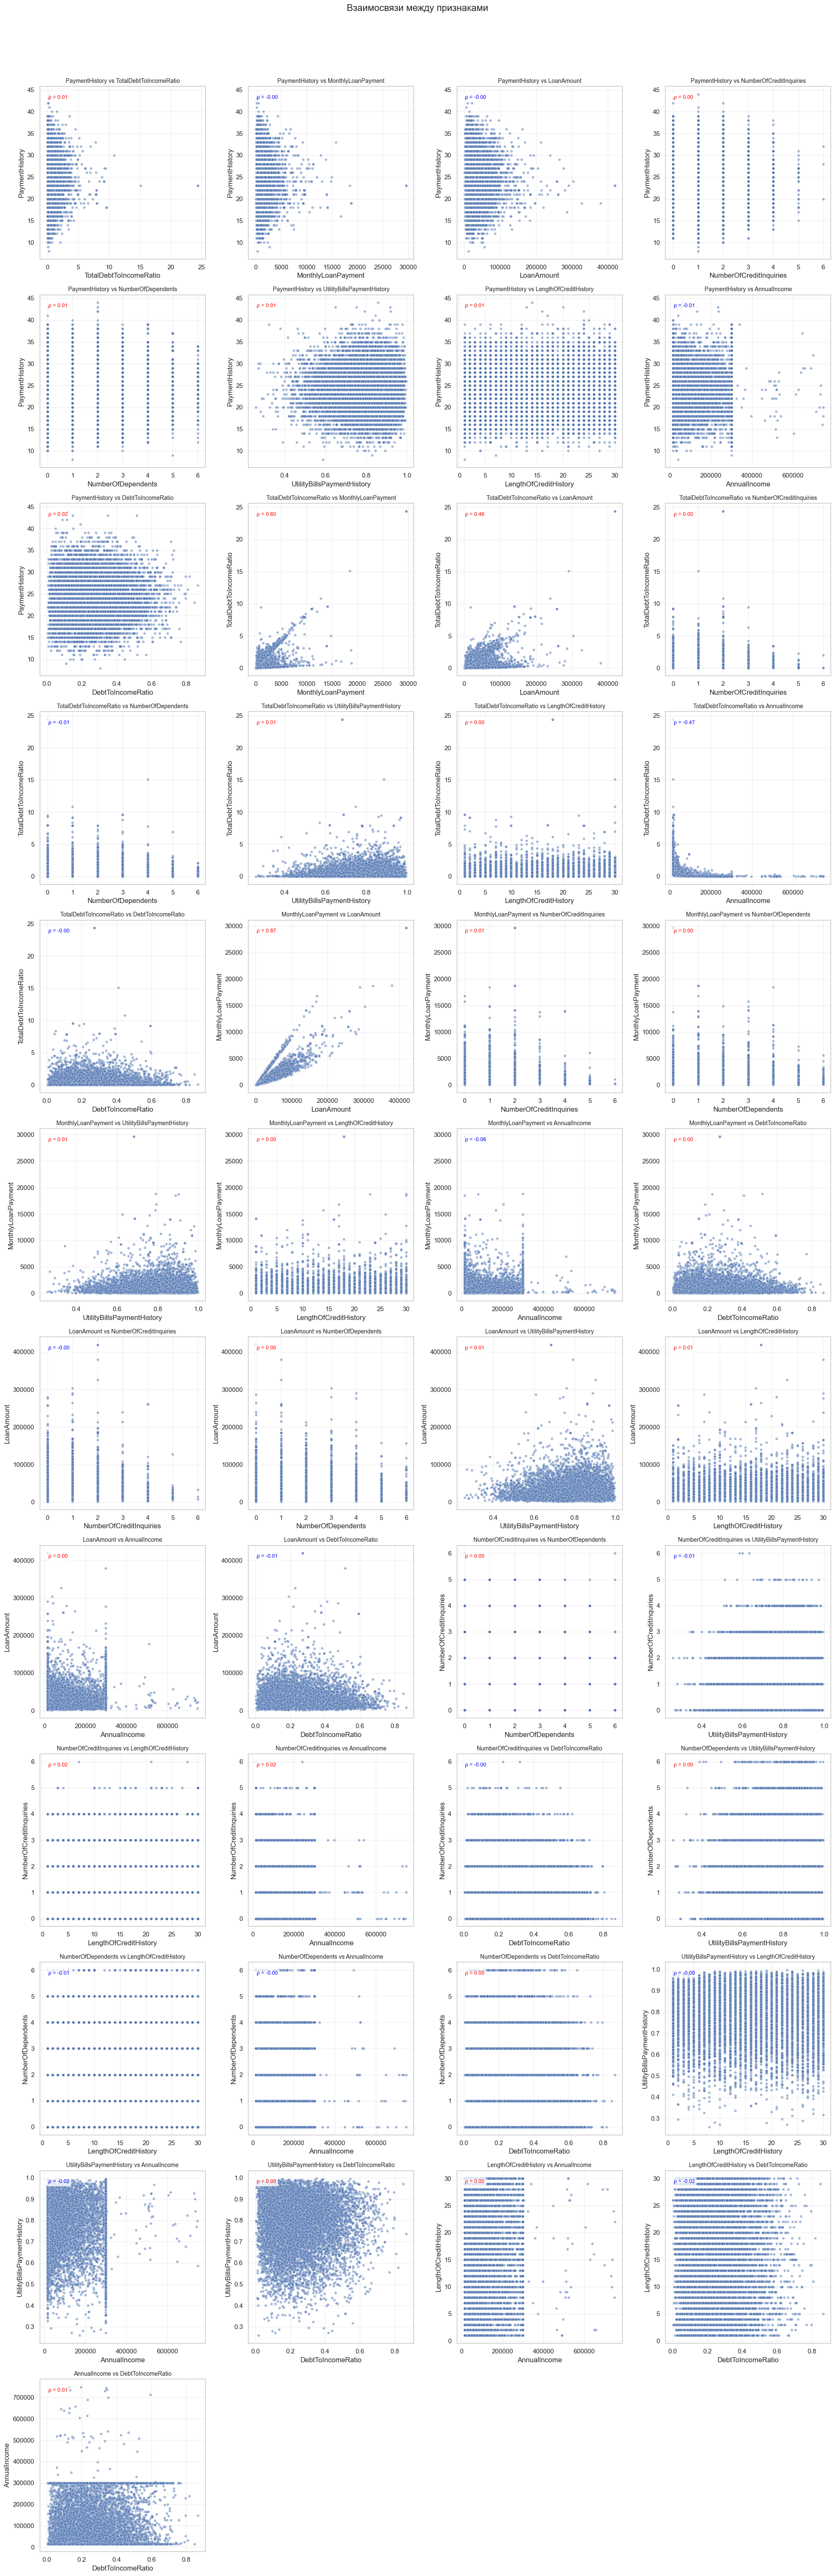

In [200]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_train['RiskScore'], fill=True, color='red')
plt.title('RiskScore')
plt.show()

num_cols = df_train.select_dtypes(include=[np.number]).columns
print(f"Количество числовых признаков: {len(num_cols)}")
print(f"Признаки: {list(num_cols)}")

corr_mat = df_train[num_cols].corr()
print("Топ положительных корреляций с RiskScore:")
print(corr_mat['RiskScore'].sort_values(ascending=False).head(11)[1:])
print("Топ отрицательных корреляций с RiskScore:")
print(corr_mat['RiskScore'].sort_values(ascending=True).head(10))

mask_tri = np.triu(np.ones_like(corr_mat, dtype=bool))
plt.figure(figsize=(20, 16))
sns.heatmap(corr_mat, mask=mask_tri, annot=False, cmap='coolwarm',
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций всех числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

feat_list = [
    'PaymentHistory', 'TotalDebtToIncomeRatio', 'MonthlyLoanPayment',
    'LoanAmount', 'NumberOfCreditInquiries', 'NumberOfDependents',
    'UtilityBillsPaymentHistory', 'LengthOfCreditHistory', 'AnnualIncome',
    'DebtToIncomeRatio',
]

data_subset = df_train[feat_list]
n_feat = len(feat_list)
total_pairs = ((n_feat - 1) * n_feat) // 2
cols_per_row = 4
rows_cnt = (total_pairs + cols_per_row - 1) // cols_per_row
fig, ax_arr = plt.subplots(rows_cnt, cols_per_row, figsize=(20, 5*rows_cnt))
ax_arr = ax_arr.ravel()
idx_plot = 0

for i in range(n_feat):
    for j in range(i + 1, n_feat):
        ax = ax_arr[idx_plot]
        sns.scatterplot(x=feat_list[j], y=feat_list[i],
                        data=data_subset, alpha=0.5, s=20, ax=ax)
        
        rho_val = data_subset[feat_list[i]].corr(data_subset[feat_list[j]])
        txt_color = 'red' if rho_val > 0 else 'blue'
        ax.text(0.05, 0.95, f'ρ = {rho_val:.2f}', transform=ax.transAxes,
                fontsize=9, color=txt_color, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(f'{feat_list[i]} vs {feat_list[j]}', fontsize=10)
        ax.grid(True, alpha=0.3)
        idx_plot += 1

for k in range(idx_plot, len(ax_arr)):
    ax_arr[k].axis('off')

plt.suptitle('Взаимосвязи между признаками', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [201]:
EPSILON = 1e-8

def calc_mse(t, p):
    return np.mean((t - p) ** 2)

def calc_mae(t, p):
    return np.mean(np.abs(t - p))

def calc_mape(t, p):
    return np.mean(np.abs((t - p) / (t + EPSILON))) * 100

def calc_r2(t, p):
    res_sum = np.sum((t - p) ** 2)
    tot_sum = np.sum((t - np.mean(t)) ** 2)
    return 1 - res_sum / (tot_sum + EPSILON)

In [202]:
class CustomLinReg:
    def __init__(self, solve_type='analytical', regularization=None, alpha=0.01,
                 learn_rate=0.01, max_iter=1000, batch_sz=32, power=2):
        self.solve_type = solve_type
        self.regularization = regularization
        self.alpha = alpha
        self.learn_rate = learn_rate
        self.max_iter = max_iter
        self.batch_sz = batch_sz
        self.power = power
        self.coefs = np.array([])
        self.intercept = 0

    def _solve_closed(self, X, y, n):
        X_aug = np.hstack([np.ones((n, 1)), X])
        if self.regularization == 'l2':
            ident = np.eye(X_aug.shape[1])
            ident[0,0] = 0
            theta = np.linalg.pinv(X_aug.T @ X_aug + self.alpha * ident) @ X_aug.T @ y
        else:
            theta = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ y
        self.intercept = theta[0]
        self.coefs = theta[1:]

    def _solve_gd(self, X, y, n):
        for _ in range(self.max_iter):
            preds = X @ self.coefs + self.intercept
            error = preds - y
            grad_w = 2 / n * X.T @ error
            grad_b = 2 / n * np.sum(error)
            
            if self.regularization == 'l1':
                grad_w += self.alpha * np.sign(self.coefs)
            elif self.regularization == 'l2':
                grad_w += 2 * self.alpha * self.coefs
            elif self.regularization == 'elastic':
                grad_w += self.alpha * (0.5 * np.sign(self.coefs) + self.coefs)
            elif self.regularization == 'lp':
                grad_w += self.alpha * self.power * np.sign(self.coefs) * (np.abs(self.coefs) ** (self.power - 1))
                
            self.coefs -= self.learn_rate * grad_w
            self.intercept -= self.learn_rate * grad_b

    def _solve_sgd(self, X, y, n):
        for _ in range(self.max_iter):
            perm = np.random.permutation(n)
            X_shuf = X[perm]
            y_shuf = y[perm]
            for start in range(0, n, self.batch_sz):
                end = start + self.batch_sz
                X_b = X_shuf[start:end]
                y_b = y_shuf[start:end]
                
                preds = X_b @ self.coefs + self.intercept
                error = preds - y_b
                grad_w = 2 / len(X_b) * X_b.T @ error
                grad_b = 2 / len(X_b) * np.sum(error)
                
                if self.regularization == 'l1':
                    grad_w += self.alpha * np.sign(self.coefs)
                elif self.regularization == 'l2':
                    grad_w += 2 * self.alpha * self.coefs
                elif self.regularization == 'elastic':
                    grad_w += self.alpha * (0.5 * np.sign(self.coefs) + self.coefs)
                elif self.regularization == 'lp':
                    grad_w += self.alpha * self.power * np.sign(self.coefs) * (np.abs(self.coefs) ** (self.power - 1))
                    
                self.coefs -= self.learn_rate * grad_w
                self.intercept -= self.learn_rate * grad_b

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_feats = X.shape
        self.coefs = np.zeros(n_feats)
        self.intercept = 0
        
        if self.solve_type == 'analytical':
            self._solve_closed(X, y, n_samples)
        elif self.solve_type == 'gd':
            self._solve_gd(X, y, n_samples)
        elif self.solve_type == 'sgd':
            self._solve_sgd(X, y, n_samples)
        else:
            raise ValueError(f'Unknown solve_type: {self.solve_type}')

    def predict(self, X):
        return np.dot(np.array(X), self.coefs) + self.intercept

In [203]:
class DataPipeline:
    def __init__(self, model_kind='sklearn', lr=0.01, epochs=1000, batch=128,
                 scaler='zscore', reg=None, alpha=0.01, power=2):
        self.model_kind = model_kind
        self.lr = lr
        self.epochs = epochs
        self.batch = batch
        self.scaler = scaler
        self.reg = reg
        self.alpha = alpha
        self.power = power
        self._init_components()

    def _init_components(self):
        self.num_med = None
        self.cat_mode = None
        self.num_mu = None
        self.num_sig = None
        self.num_lo = None
        self.num_hi = None
        self.poly_exp = None
        self.poly_mu = None
        self.poly_sig = None
        self.cat_enc = None
        self.best_cols = None
        self.model = None

    def _log_trans(self, arr):
        return np.sign(arr) * np.log1p(np.abs(arr))

    def _normalize(self, frame, cols, is_fit=True):
        if self.scaler == 'zscore':
            if is_fit:
                self.num_mu = frame[cols].mean()
                self.num_sig = frame[cols].std().replace(0, 1)
            normed = (frame[cols] - self.num_mu) / self.num_sig
        elif self.scaler == 'minmax':
            if is_fit:
                self.num_lo = frame[cols].min()
                self.num_hi = frame[cols].max()
            denom = self.num_hi - self.num_lo + EPSILON
            normed = (frame[cols] - self.num_lo) / denom
        frame = frame.copy()
        frame[cols] = normed
        return frame

    def _process_num(self, frame, cols, is_fit=True):
        frame = frame.copy()
        if is_fit:
            self.num_med = frame[cols].median()
        frame[cols] = frame[cols].fillna(self.num_med)
        frame[cols] = self._log_trans(frame[cols])
        frame = self._normalize(frame, cols, is_fit)
        return frame

    def _process_cat(self, frame, cols, is_fit=True):
        frame = frame.copy()
        if is_fit:
            self.cat_mode = frame[cols].mode().iloc[0]
            self.cat_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            self.cat_enc.fit(frame[cols])
        frame[cols] = frame[cols].fillna(self.cat_mode)
        enc_mat = self.cat_enc.transform(frame[cols])
        enc_names = self.cat_enc.get_feature_names_out(cols)
        return pd.DataFrame(enc_mat, columns=enc_names, index=frame.index)

    def _make_poly(self, frame, cols, is_fit=True):
        if is_fit:
            self.poly_exp = PolynomialFeatures(degree=2, include_bias=False)
            self.poly_exp.fit(frame[cols])
        poly_mat = self.poly_exp.transform(frame[cols])
        poly_names = self.poly_exp.get_feature_names_out(cols)
        poly_df = pd.DataFrame(poly_mat, columns=poly_names, index=frame.index)
        if is_fit:
            self.poly_mu = poly_df.mean()
            self.poly_sig = poly_df.std().replace(0, 1)
        poly_df = (poly_df - self.poly_mu) / self.poly_sig
        return poly_df

    def _choose_best(self, feats, target, is_fit=True):
        if is_fit:
            corr_vals = feats.apply(lambda col: col.corr(pd.Series(target)))
            abs_corr = corr_vals.abs().sort_values(ascending=False)
            keep_cnt = max(1, int(0.30 * len(feats.columns)))
            self.best_cols = abs_corr.head(keep_cnt).index.tolist()
        return feats[self.best_cols].values

    def fit(self, X, y, num_cols, cat_cols):
        X = X.copy()
        X_num = self._process_num(X, num_cols, True)
        poly_part = self._make_poly(X_num, num_cols, True)
        cat_part = self._process_cat(X, cat_cols, True)
        full_feats = pd.concat([poly_part, cat_part], axis=1)
        chosen = self._choose_best(full_feats, y, True)
        
        if self.model_kind == 'sklearn':
            self.model = LinearRegression()
        else:
            self.model = CustomLinReg(
                solve_type=self.model_kind,
                regularization=self.reg,
                alpha=self.alpha,
                learn_rate=self.lr,
                max_iter=self.epochs,
                batch_sz=self.batch,
                power=self.power
            )
        self.model.fit(chosen, y)
        return self

    def transform(self, X, num_cols, cat_cols):
        X = X.copy()
        X_num = self._process_num(X, num_cols, False)
        poly_part = self._make_poly(X_num, num_cols, False)
        cat_part = self._process_cat(X, cat_cols, False)
        full_feats = pd.concat([poly_part, cat_part], axis=1)
        chosen = self._choose_best(full_feats, None, False)
        return chosen

    def predict(self, X, num_cols, cat_cols):
        feats = self.transform(X, num_cols, cat_cols)
        return self.model.predict(feats)

In [204]:
class SimpleKFold:
    def __init__(self, folds=5, shuf=True, seed=42):
        self.folds = folds
        self.shuf = shuf
        self.seed = seed

    def split(self, data):
        n = len(data)
        indices = np.arange(n)
        if self.shuf:
            rng = np.random.RandomState(self.seed)
            rng.shuffle(indices)
        sizes = np.full(self.folds, n // self.folds, dtype=int)
        sizes[:n % self.folds] += 1
        cur = 0
        for sz in sizes:
            test_idx = indices[cur:cur + sz]
            train_idx = np.concatenate((indices[:cur], indices[cur + sz:]))
            yield train_idx, test_idx
            cur += sz

class SimpleLOO:
    def __init__(self, shuf=True, seed=42):
        self.shuf = shuf
        self.seed = seed

    def split(self, data):
        n = len(data)
        indices = np.arange(n)
        if self.shuf:
            rng = np.random.RandomState(self.seed)
            rng.shuffle(indices)
        for i in range(n):
            test_idx = [indices[i]]
            train_idx = np.delete(indices, i)
            yield train_idx, test_idx

In [205]:
def feature_engineering(df: pd.DataFrame):
    df.drop(columns=['ApplicationDate'], inplace=True)
    
    edu_map = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
    df['EducationLevel'] = df['EducationLevel'].map(edu_map).fillna(0).astype(float)
    
    df['AvgMonthlyIncome'] = (df['MonthlyIncome'] + df['AnnualIncome'] / 12) / 2
    df['IncomeTransform'] = 1 / (np.log1p(df['AvgMonthlyIncome']) + 1)
    
    df['BaseRateExp'] = np.exp(df['BaseInterestRate'] / 100) - 1
    
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    
    df["AgeExpDiff"] = np.abs(df["Age"] - df["Experience"])
    
    df["NetIncomeRatio"] = df["NetWorth"] / (df["AnnualIncome"] + 10)
    df['NetWorthPow'] = np.log1p(np.abs(df['NetWorth'])) ** 2.5
    
    df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + 10)
    df["CreditHistRatio"] = df["LengthOfCreditHistory"] / (df["Age"] + 5)
    
    total_debt = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"] + df["UtilityBillsPaymentHistory"]
    df["FullDebtRatio"] = total_debt / (df["MonthlyIncome"] + 10)
    df["FreeIncome"] = df["MonthlyIncome"] - total_debt
    
    df["AssetToLiab"] = df["TotalAssets"] / (df["TotalLiabilities"] + 10)
    df["NetAssetValue"] = df["TotalAssets"] - df["TotalLiabilities"]
    
    df["IncomePerDependent"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 2)
    df["ExpToAgeRatio"] = df["Experience"] / (df["Age"] + 5)
    
    df['AnnualIncomeLog'] = np.log1p(df['AnnualIncome'])
    df['BaseInterestRateLog'] = np.log1p(df['BaseInterestRate'])
    df['LoanAmountLog'] = np.log1p(df['LoanAmount'])
    
    bins = [200, 500, 600, 650, 700, 750, 800, 850, 950]
    labels = [f'{l}-{r}' for l, r in zip(bins[:-1], bins[1:])]
    df['CreditScoreBin'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, include_lowest=True).astype(str)

In [206]:
df_train = df_train.dropna(subset=['RiskScore'])
df_train = df_train[df_train['RiskScore'].abs() <= 200].reset_index(drop=True)
df_train['RiskScore'] = df_train['RiskScore'].clip(0.0, 100.0)

feature_engineering(df_train)
feature_engineering(df_test)

X_full = df_train.drop(columns=['RiskScore'])
y_full = df_train['RiskScore']
X_test_final = df_test.drop(columns=['ID'])

num_features = X_full.select_dtypes(include=[np.number]).columns.tolist()
cat_features = list(set(X_full.columns) - set(num_features))

In [207]:
configs = [
    ['sklearn', None, None, 0],
    ['analytical', None, None, 0],
    ['analytical', 'l2', 100, 0],
    ['gd', None, None, 0],
    ['gd', 'l1', 0.1, 0],
    ['gd', 'l2', 0.001, 0],
    ['gd', 'lp', 0.1, 3],
    ['sgd', None, None, 0],
]

print('='*20)
print('Cross-validation:')
print('='*20)

cv_mse = {}
kfold_cv = SimpleKFold()

for cfg_type, cfg_reg, cfg_alpha, cfg_p in configs:
    scores = []
    for tr_idx, val_idx in kfold_cv.split(X_full):
        X_tr = X_full.iloc[tr_idx].copy()
        X_val = X_full.iloc[val_idx].copy()
        y_tr = y_full.iloc[tr_idx]
        y_val = y_full.iloc[val_idx]
        
        pl = DataPipeline(model_kind=cfg_type, reg=cfg_reg, alpha=cfg_alpha, power=cfg_p)
        pl.fit(X_tr, y_tr, num_features, cat_features)
        preds = pl.predict(X_val, num_features, cat_features)
        scores.append(calc_mse(y_val, preds))
    
    avg_mse = np.mean(scores)
    cv_mse[cfg_type] = avg_mse
    reg_str = cfg_reg if cfg_reg else ''
    alpha_str = cfg_alpha if cfg_alpha else ''
    p_str = cfg_p if cfg_p else ''
    print(f' {cfg_type}({reg_str},{alpha_str},{p_str}): mse = {avg_mse:.3f}')

Cross-validation:
 sklearn(,,): mse = 26.604
 analytical(,,): mse = 26.748
 analytical(l2,100,): mse = 26.270
 gd(,,): mse = 29.631
 gd(l1,0.1,): mse = 30.757
 gd(l2,0.001,): mse = 29.615
 gd(lp,0.1,3): mse = 29.779
 sgd(,,): mse = 29.170


In [208]:
final_pl = DataPipeline(model_kind='analytical')
final_pl.fit(X_full, y_full, num_features, cat_features)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
final_pl.fit(X_train_split, y_train_split, num_features, cat_features)
val_preds = final_pl.predict(X_val_split, num_features, cat_features)

print('='*20)
print('Сравнение реализованных метрик с sklearn:')
print('='*20)
print(f' MSE: custom - {calc_mse(y_val_split, val_preds)}, sklearn - {mean_squared_error(y_val_split, val_preds)}')
print(f' MAE: custom - {calc_mae(y_val_split, val_preds)}, sklearn - {mean_absolute_error(y_val_split, val_preds)}')
print(f' MAPE: custom - {calc_mape(y_val_split, val_preds)}, sklearn - {mean_absolute_percentage_error(y_val_split, val_preds)*100}')
print(f' R2: custom - {calc_r2(y_val_split, val_preds)}, sklearn - {r2_score(y_val_split, val_preds)}')

Сравнение реализованных метрик с sklearn:
 MSE: custom - 26.317863703293813, sklearn - 26.317863703293813
 MAE: custom - 3.6727858765493164, sklearn - 3.6727858765493164
 MAPE: custom - 8.592335918086647, sklearn - 8.59233592035551
 R2: custom - 0.9119960731056578, sklearn - 0.9119960731056563


In [209]:
test_predictions = final_pl.predict(X_test_final, num_features, cat_features)
test_predictions = np.clip(test_predictions, 0.0, 100.0)

submission_df = pd.DataFrame({
    'ID': pd.Series(np.arange(len(df_test)), name='ID'),
    'RiskScore': test_predictions
})
submission_df.to_csv(output, index=False)
print("Предсказания сохранены в", output)

Предсказания сохранены в ./submissions.csv
